<a href="https://colab.research.google.com/github/Iskhand/Dataset-Brain-Tumor/blob/master/BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install -q kaggle

In [14]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
!cp kaggle.json ~/.kaggle/

In [16]:
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle datasets download -d jakeshbohaju/brain-tumor

 36% 5.00M/14.0M [00:00<00:00, 39.0MB/s]
100% 14.0M/14.0M [00:00<00:00, 84.6MB/s]


In [18]:
import zipfile
import os

with zipfile.ZipFile('brain-tumor.zip', 'r') as zip_ref:
    zip_ref.extractall('brain-tumor')


In [23]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL.Image import open
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [26]:
data = pd.read_csv("/content/brain-tumor/Brain Tumor.csv")

dataset_size = data.shape
print("Ukuran Dataset:", dataset_size)

column_names = data.columns.tolist()
print("Nama Kolom:", column_names)

Ukuran Dataset: (3762, 15)
Nama Kolom: ['Image', 'Class', 'Mean', 'Variance', 'Standard Deviation', 'Entropy', 'Skewness', 'Kurtosis', 'Contrast', 'Energy', 'ASM', 'Homogeneity', 'Dissimilarity', 'Correlation', 'Coarseness']


In [19]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_folder = '/content/brain-tumor/Brain Tumor/Brain Tumor'

# Tentukan persentase pembagian data
persentase_train = 0.8
persentase_test = 0.2

# Ambil list semua file di folder dataset
files = os.listdir(dataset_folder)

# Pisahkan data training dan testing
train_files, test_files = train_test_split(files, test_size=persentase_test, random_state=42)

# Buat folder data training dan testing
train_folder = os.path.join('/content/brain-tumor/Data', f'training_data')
test_folder = os.path.join('/content/brain-tumor/Data', f'testing_data')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Pindahkan file ke folder yang sesuai
for file in train_files:
    shutil.copy(os.path.join(dataset_folder, file), os.path.join(train_folder, file))

for file in test_files:
    shutil.copy(os.path.join(dataset_folder, file), os.path.join(test_folder, file))


In [21]:
image_dataset = "/content/brain-tumor/Brain Tumor/Brain Tumor"
image_dataset_raw = r"\content\brain-tumor\Brain Tumor\Brain Tumor"
working_folder = "/kaggle/working"
img_height = 224
img_width = 224
epochs = 50

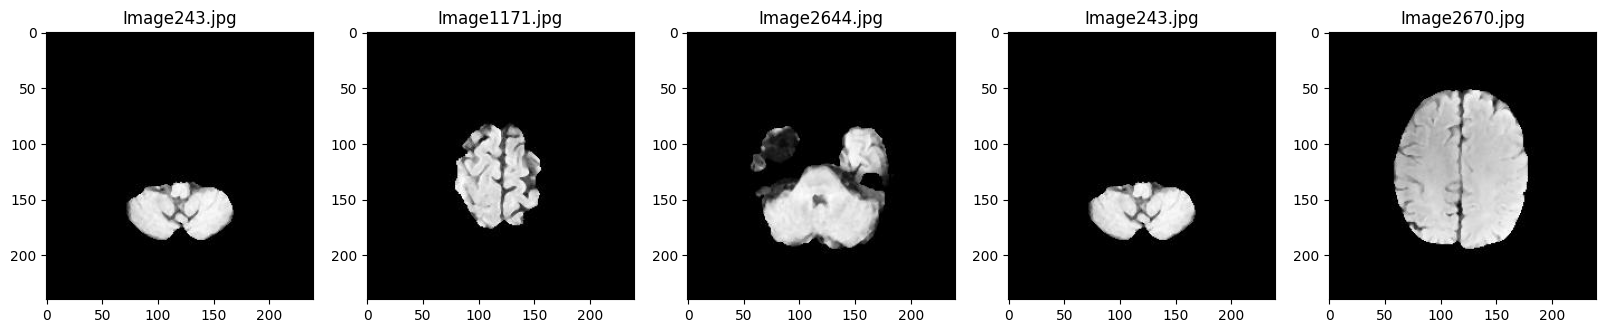

In [24]:
plt.figure(figsize=(20,20))
test_folder="/content/brain-tumor/Data/testing_data"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [27]:
dataset_df = pd.DataFrame()
dataset_df["Image"] = data["Image"]
dataset_df["Class"] = data["Class"]

path_list = []
for img_path in os.listdir(image_dataset):
    path_list.append( os.path.join(image_dataset,img_path))
    path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
dataset_df["paths"] = data["Image"].map(path_dict.get)

dataset_df["pixels"] = dataset_df["paths"].map(lambda x:np.asarray(open(x).resize((img_height,img_width))))
dataset_df.head()

,Image,Class,paths,pixels
0,Image1,0,/content/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,/content/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,/content/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,/content/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,/content/brain-tumor/Brain Tumor/Brain Tumor/I...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [28]:
image_list = []
for i in range(len(dataset_df)):
    brain_image = dataset_df["pixels"][i].astype(np.float32)
    brain_image /= 255
    image_list.append(brain_image)

X = np.array(image_list)
#print(X.shape)

y = np.array(dataset_df.Class)
#print(y.shape)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Bentuk dari X_train:', X_train.shape)
print('Ukuran X_train:', X_train.shape[0])
print('Bentuk dari X_test:', X_test.shape)
print('Ukuran de X_test:', X_test.shape[0])

Bentuk dari X_train: (3009, 224, 224, 3)
Ukuran X_train: 3009
Bentuk dari X_test: (753, 224, 224, 3)
Ukuran de X_test: 753


In [30]:
def model(input_shape):
    model = Sequential()

    model.add(Input(shape=input_shape))
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))

    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))

    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    return model

model = model(input_shape=(img_height, img_width, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                   

In [31]:
optimizer = SGD(learning_rate=0.01)
loss_fn = BinaryCrossentropy(from_logits=False)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [32]:
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=10)

Epoch 1/50
301/301 [==============================] - 30s 96ms/step - loss: 0.6019 - accuracy: 0.6933
Epoch 2/50
301/301 [==============================] - 25s 85ms/step - loss: 0.4938 - accuracy: 0.7714
Epoch 3/50
301/301 [==============================] - 26s 86ms/step - loss: 0.4547 - accuracy: 0.7920
Epoch 4/50
301/301 [==============================] - 24s 80ms/step - loss: 0.4160 - accuracy: 0.8126
Epoch 5/50
301/301 [==============================] - 24s 78ms/step - loss: 0.3679 - accuracy: 0.8382
Epoch 6/50
301/301 [==============================] - 23s 75ms/step - loss: 0.3335 - accuracy: 0.8488
Epoch 7/50
301/301 [==============================] - 24s 81ms/step - loss: 0.2969 - accuracy: 0.8724
Epoch 8/50
301/301 [==============================] - 23s 77ms/step - loss: 0.2581 - accuracy: 0.8933
Epoch 9/50
301/301 [==============================] - 23s 78ms/step - loss: 0.2386 - accuracy: 0.8966
Epoch 10/50
301/301 [==============================] - 24s 80ms/step - loss: 0.229

In [33]:
model.save("BrainTumorv2")

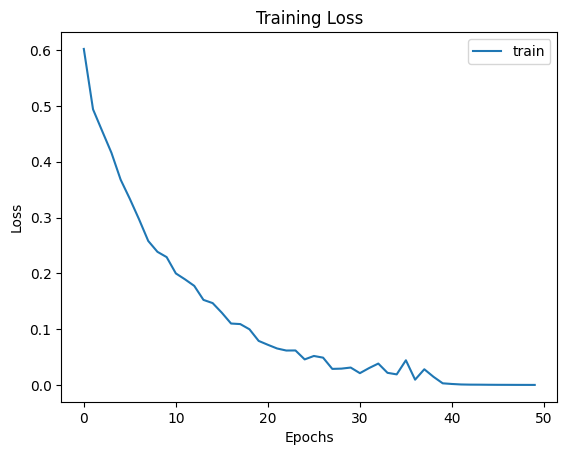

In [34]:
loss = history.history["loss"]
acc = history.history["accuracy"]

epoch = np.arange(epochs)
plt.plot(epoch, loss)
# plt.plot(epoch, val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['train', 'val'])

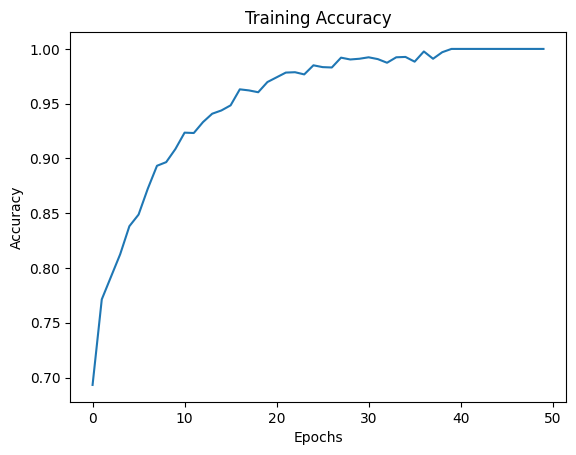

In [35]:
epoch = np.arange(epochs)
plt.plot(epoch, acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy');

In [36]:
eval_score = model.evaluate(X_test, y_test)
print("Test loss:", eval_score[0])
print("Test accuracy:", eval_score[1])

24/24 [==============================] - 2s 77ms/step - loss: 0.2840 - accuracy: 0.9628
Test loss: 0.283957302570343
Test accuracy: 0.9628154039382935


In [37]:
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test accuracy:", accuracy)

Test accuracy: 0.9628154039382935
